In [68]:
import numpy as np
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from Code.fixed_income_derivatives_E2024 import *
from scipy.optimize import minimize
from scipy.stats import norm

In [69]:
#2.a)
def vasicek_confidence_interval(T, r0, a, b, sigma, alpha, stationary=False):
    z = norm.ppf(1 - alpha/2, 0, 1)
    if stationary:
        mean = b / a
        variance = sigma**2 / (2 * a)
        sigma = np.sqrt(variance)
    else:
        mean = r0 * np.exp(-a * T) + b / a * (1 - np.exp(-a * T))
        variance = sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T))
        sigma = np.sqrt(variance)
    return mean - z * sigma, mean + z * sigma

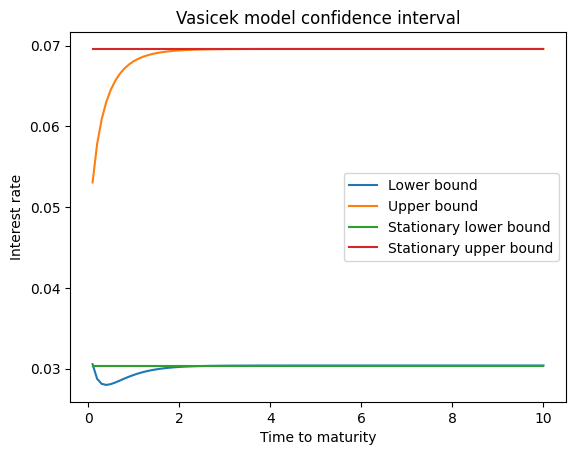

In [70]:
#2.b)
alpha = 0.05
r0 = 0.04
a = 2
b = 0.1
sigma = 0.02
T = np.linspace(0.1, 10, 100)
confidence_interval = np.array([vasicek_confidence_interval(t, r0, a, b, sigma, alpha) for t in T])
stationary_confidence_interval = np.array([vasicek_confidence_interval(t, r0, a, b, sigma, alpha, True) for t in T])
plt.plot(T, confidence_interval[:, 0], label='Lower bound')
plt.plot(T, confidence_interval[:, 1], label='Upper bound')
plt.plot(T, stationary_confidence_interval[:, 0], label='Stationary lower bound')
plt.plot(T, stationary_confidence_interval[:, 1], label='Stationary upper bound')
plt.xlabel('Time to maturity')
plt.ylabel('Interest rate')
plt.title('Vasicek model confidence interval')
plt.legend()
plt.show()

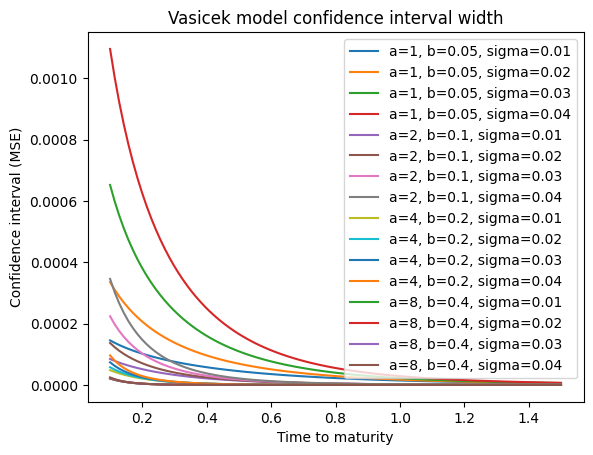

In [71]:
#2.c)
alpha = 0.05
r0 = 0.04
a = np.array([1, 2, 4, 8])
b = 0.05*a
sigma = np.array([0.01, 0.02, 0.03, 0.04])
T = np.linspace(0.1, 1.5, 100)
for i in range(len(a)):
    for j in range(len(sigma)):
        confidence_interval = np.array([vasicek_confidence_interval(t, r0, a[i], b[i], sigma[j], alpha) for t in T])
        stationary_confidence_interval = np.array([vasicek_confidence_interval(t, r0, a[i], b[i], sigma[j], alpha, True) for t in T])
        mse = np.mean((confidence_interval - stationary_confidence_interval)**2, axis=1)
        plt.plot(T, mse, label=f'a={a[i]}, b={b[i]}, sigma={sigma[j]}')
plt.xlabel('Time to maturity')
plt.ylabel('Confidence interval (MSE)')
plt.title('Vasicek model confidence interval width')
plt.legend()
plt.show()

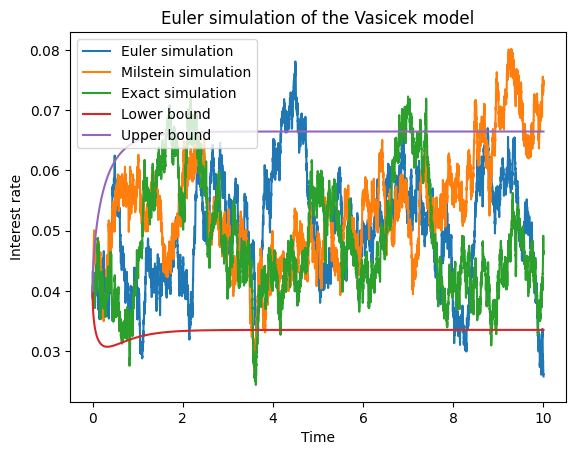

In [72]:
#2.d - 2.e)
#Euler and Milstein schemes are equivalent for the Vasicek model
t0 = 0
T_terminal = 10
M = 10_000
delta = T_terminal/M
T = np.arange(t0, M + 1)*delta
r0 = 0.04
a = 2
b = 0.1
sigma = 0.02
alpha = 0.1
r_euler = [r0]
r_milstein = [r0]
r_exact = [r0]
for i in range(M):
    r_euler.append(r_euler[-1] + (b - a*r_euler[-1])*delta + sigma*np.sqrt(delta)*np.random.normal())
    r_milstein.append(r_milstein[-1] + (b - a*r_milstein[-1])*delta + sigma*np.sqrt(delta)*np.random.normal())
    r_exact.append(r_exact[-1]*np.exp(-a*delta) + b/a*(1 - np.exp(-a*delta)) + sigma*np.sqrt((1 - np.exp(-2*a*delta))/(2*a))*np.random.normal())
confidence_interval = np.array([vasicek_confidence_interval(t, r0, a, b, sigma, alpha) for t in T])
r_euler = np.array(r_euler)
plt.plot(T, r_euler, label='Euler simulation')
plt.plot(T, r_milstein, label='Milstein simulation')
plt.plot(T, r_exact, label='Exact simulation')
plt.plot(T, confidence_interval[:,0], label='Lower bound')
plt.plot(T, confidence_interval[:,1], label='Upper bound')
plt.xlabel('Time')
plt.ylabel('Interest rate')
plt.title('Euler simulation of the Vasicek model')
plt.legend()
plt.show()

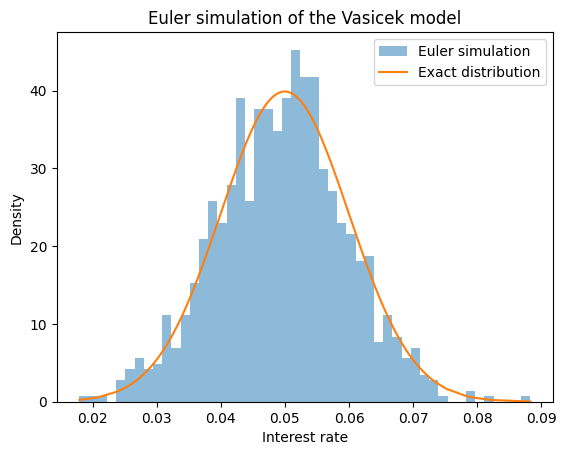

In [73]:
#2.f)
T_terminal = 3
N = 1000
M = 1000
delta = T_terminal/M
T = np.arange(0, M + 1)*delta
r0 = 0.04
a = 2
b = 0.1
sigma = 0.02
alpha = 0.05
r_euler_3 = np.ones(N)*r0
r_milstein_3 = np.ones(N)*r0
r_exact_3 = np.ones(N)*r0
for i in range(N):
    for _ in range(M):
        r_euler_3[i] = r_euler_3[i] + (b - a*r_euler_3[i])*delta + sigma*np.sqrt(delta)*np.random.normal()
        r_milstein_3[i] = r_milstein_3[i] + (b - a*r_milstein_3[i])*delta + sigma*np.sqrt(delta)*np.random.normal()
        r_exact_3[i] = r_exact_3[i]*np.exp(-a*delta) + b/a*(1 - np.exp(-a*delta)) + sigma*np.sqrt((1 - np.exp(-2*a*delta))/(2*a))*np.random.normal()
r_euler_3.sort()
y = np.array(norm.pdf(r_euler_3, np.exp(-a*T_terminal)*r0 + b/a*(1 - np.exp(-a*T_terminal)), np.sqrt(sigma**2/(2*a)*(1 - np.exp(-2*a*T_terminal)))))
bins = np.linspace(min(r_euler_3), max(r_euler_3), 50)
plt.hist(r_euler_3, bins=bins, density=True, alpha=0.5, label='Euler simulation')
plt.plot(r_euler_3, y, label='Exact distribution')
plt.xlabel('Interest rate')
plt.ylabel('Density')
plt.title('Euler simulation of the Vasicek model')
plt.legend()
plt.show()

In [109]:
#2.g)
T_terminal = 3
N = np.array([2000, 4000, 6000, 8000, 10000])
M = np.array([2000, 4000, 6000, 8000, 10000])
delta = T_terminal/M
r0 = 0.04
a = 2
b = 0.1
sigma = 0.02
alpha = 0.05
results_euler_3 = np.zeros((len(N), len(M)))
results_milstein_3 = np.zeros((len(N), len(M)))
results_exact_3 = np.zeros((len(N), len(M)))
bins = np.linspace(0.01, 0.09, 101)
for i in range(len(N)):
    for j in range(len(M)):
        print(f'N={N[i]}, M={M[j]}')
        r_euler_3 = np.ones(N[i])*r0
        r_milstein_3 = np.ones(N[i])*r0
        r_exact_3 = np.ones(N[i])*r0
        for _ in range(M[j]):
            r_euler_3 = r_euler_3 + (b - a*r_euler_3)*delta[j] + sigma*np.sqrt(delta[j])*np.random.normal(size=N[i])
            r_milstein_3 = r_milstein_3 + (b - a*r_milstein_3)*delta[j] + sigma*np.sqrt(delta[j])*np.random.normal(size=N[i])
            r_exact_3 = r_exact_3*np.exp(-a*delta[j]) + b/a*(1 - np.exp(-a*delta[j])) + sigma*np.sqrt((1 - np.exp(-2*a*delta[j]))/(2*a))*np.random.normal(size=N[i])
        cdf_1 = np.array(norm.cdf(bins[:100], np.exp(-a*T_terminal)*r0 + b/a*(1 - np.exp(-a*T_terminal)), np.sqrt(sigma**2/(2*a)*(1 - np.exp(-2*a*T_terminal)))))
        cdf_2 = np.array(norm.cdf(bins[1:], np.exp(-a*T_terminal)*r0 + b/a*(1 - np.exp(-a*T_terminal)), np.sqrt(sigma**2/(2*a)*(1 - np.exp(-2*a*T_terminal)))))
        norm_1 = cdf_2 - cdf_1
        results_euler_3[i, j] = np.sum((np.histogram(r_euler_3, bins=bins, density=False)[0]/N[i] - norm_1)**2)
        results_milstein_3[i, j] = np.sum((np.histogram(r_milstein_3, bins=bins, density=False)[0]/N[i] - norm_1)**2)
        results_exact_3[i, j] = np.sum((np.histogram(r_exact_3, bins=bins, density=False)[0]/N[i] - norm_1)**2)

N=2000, M=2000
N=2000, M=4000
N=2000, M=6000
N=2000, M=8000
N=2000, M=10000
N=4000, M=2000
N=4000, M=4000
N=4000, M=6000
N=4000, M=8000
N=4000, M=10000
N=6000, M=2000
N=6000, M=4000
N=6000, M=6000
N=6000, M=8000
N=6000, M=10000
N=8000, M=2000
N=8000, M=4000
N=8000, M=6000
N=8000, M=8000
N=8000, M=10000
N=10000, M=2000
N=10000, M=4000
N=10000, M=6000
N=10000, M=8000
N=10000, M=10000


In [110]:
print("Euler simulation:" , results_euler_3)
print("Milstein simulation:" , results_milstein_3)
print("Exact simulation:" , results_exact_3)

Euler simulation: [[4.28870369e-04 5.40612832e-04 7.79730315e-04 5.20374611e-04
  3.20871819e-04]
 [2.23639411e-04 2.15803389e-04 2.33294496e-04 1.92158381e-04
  2.35739913e-04]
 [9.01297337e-05 1.83609319e-04 1.74459491e-04 1.59075199e-04
  1.60966983e-04]
 [9.86025076e-05 1.15840051e-04 1.31142065e-04 1.02247766e-04
  9.49435338e-05]
 [1.06819289e-04 9.33901534e-05 1.11300888e-04 1.20922922e-04
  1.21346241e-04]]
Milstein simulation: [[0.00042421 0.00075199 0.00054964 0.00060723 0.00063091]
 [0.00018834 0.00034364 0.00025018 0.00028968 0.00021238]
 [0.00018347 0.00012236 0.00010239 0.00014652 0.00019112]
 [0.00017505 0.00012689 0.00018013 0.00013573 0.00013612]
 [0.00010078 0.00010365 0.00010562 0.00010098 0.00012912]]
Exact simulation: [[5.54583222e-04 5.11610751e-04 5.55595621e-04 4.30328709e-04
  4.62921424e-04]
 [2.10122948e-04 2.69577827e-04 2.56535079e-04 2.71522080e-04
  2.66803537e-04]
 [1.24623407e-04 1.29388496e-04 1.96346979e-04 1.37795149e-04
  1.81529735e-04]
 [1.0628875